# 6. Quantum Phase Estimation vs. Hadamard Test

In [17]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
token = input('Enter API token: ')

Enter API token:  d17e870f9f5859e3ffcf9ed4f6bfaef6b3f8f0455aeb705414cbbdc362bc65437a64d77ab88e1b319c33069acfac47c6eb158f310011f77777039806540e6817


## Table of Contents
* [Hadamard Test Simulation](#HTsim)
* [Hadamard Test Quantum Computer](#HTqc)
* [Quantum Phase Estimation Simulation](#QPEsim)
* [Quantum Phase Estimation Quantum Computer](#QPEqc)

This section entails a comparison between the HT and QPE algorithms. To ensure that the same value is estimated for both algorithms, a phase of $e^{i2\pi\varphi}$ is applied to both QPE and HT. To extract the value $\varphi$ using HT, the estimate is simply divided by $2\pi$. 
        
Consider the unitary matrix 
$$ U 
= \begin{bmatrix}
    1 & 0 \\
    0 & e^{i2\pi\varphi}
\end{bmatrix},$$
where $\varphi = 1/3$ and the goal is to estimate this value with precision $\epsilon$. 

For this comparison both algorithms are run for $20$ total trials spanning from $10^3$ to $10^5$ shots for HT and $1$ to $20$ ancillary qubits with $1000$ shots for QPE. Both approaches are run for all $20$ trials on both a fault-tolerant simulation and on the RPI IBM Quantum System One quantum computer. These parameters were chosen because they span the range of practical simulations with the given classical resources for quantum simulation.

To visualize the convergence in error with respect to each algorithm's quantum resources, their individual errors are plotted in a joint graph for both the simulation and quantum hardware. The run time of each algorithm is also estimated and plotted in a joint graph to observe how it scales for the respective algorithms per their allocated quantum resource.

## Hadamard Test Simulation <a name="HTsim"></a>

First, the Hadamard test is run on a fault-tolerant simulation as before, but with the unitary $U$ above, estimating $\varphi$.

In [18]:
angle = 1/3 #Exact value of phi to estimate
angle = angle%(2*pi)
print("Angle: ",angle, "rad")

Angle:  0.3333333333333333 rad


In [19]:
def re_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0$\u27e9')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9') 
    circuit.cp(2*pi*theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_2$\u27e9') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

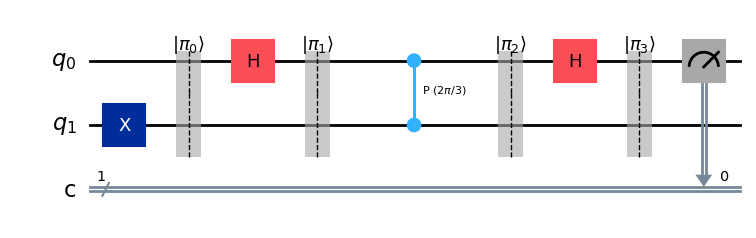

In [20]:
HTre = re_HT(angle)
HTre.draw('mpl')

In [21]:
def im_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0\u27e9$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9')
    circuit.sdg(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$|π_2$\u27e9')
    circuit.cp(2*pi*theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_4$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

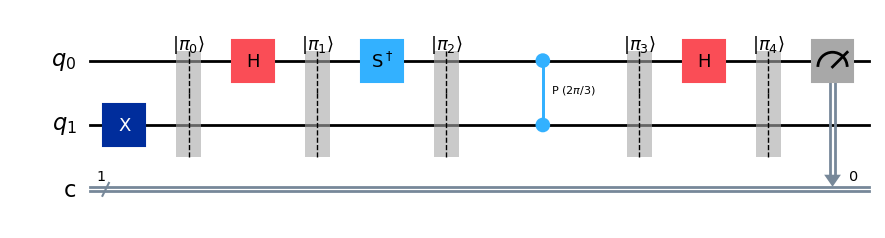

In [22]:
HTim = im_HT(angle)
HTim.draw('mpl')

In [23]:
sim = AerSimulator() # set simulator
num_shots = 1000

In [24]:
transRe = transpile(HTre, sim) # transpile real hadamard test circuit
resultRe = sim.run(transRe, shots = num_shots).result() # run transpiled circuit
countsRe = resultRe.get_counts() # retreive counts after measurement

transIm = transpile(HTim, sim) # transpile imaginary hadamard test circuit
resultIm = sim.run(transIm, shots = num_shots).result() # run transpiled circuit
countsIm = resultIm.get_counts() # retreive counts after measurement

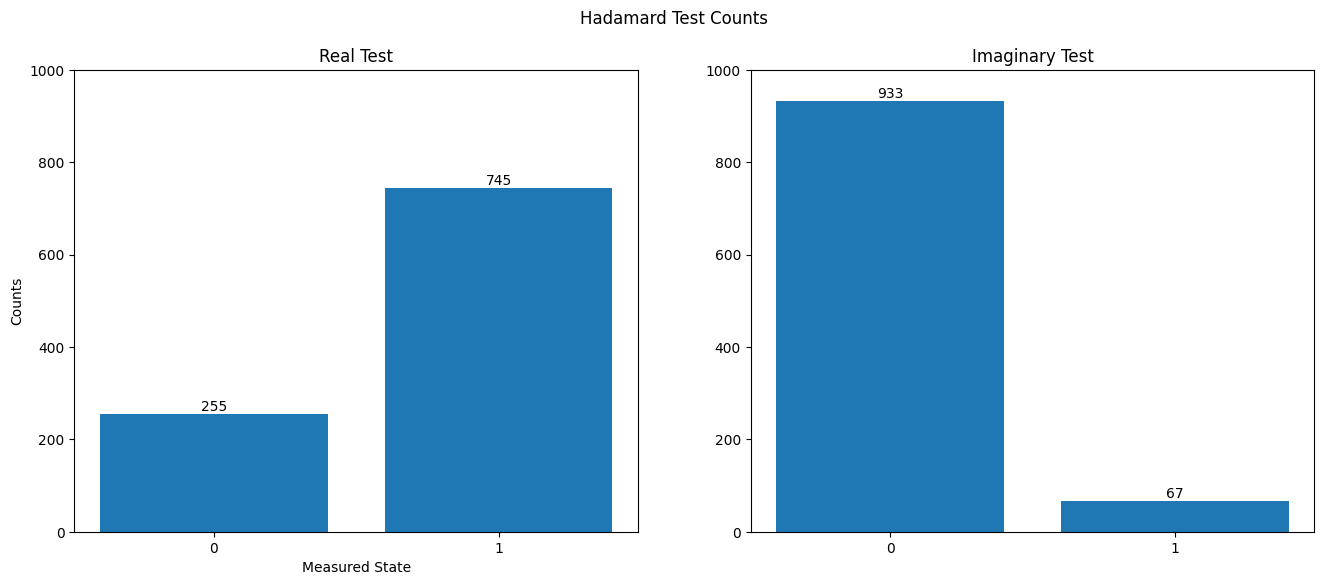

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bar0 = axes[0].bar([0,1], [countsRe.get('0'), countsRe.get('1')])

axes[0].bar_label(bar0, fmt = lambda x: int(x))
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])

bar1 = axes[1].bar([0,1], [countsIm.get('0'), countsIm.get('1')])
axes[1].bar_label(bar1, fmt = lambda x: int(x))

axes[0].set_ylim(0,num_shots)
axes[1].set_ylim(0,num_shots)

axes[0].set_xlabel('Measured State')
axes[0].set_ylabel('Counts')
axes[0].set_title('Real Test')
axes[1].set_title('Imaginary Test')

fig.suptitle('Hadamard Test Counts')
plt.show()

In [26]:
equation_number = 1 # use cosine to determine angle and sine to determine sign
# equation_number = 2 # use sine to determine angle and cosine to determine sign
# equation_number = 3 # use tan to determine angle
re_p0 = re_p1 = im_p0 = im_p1 = 0

if countsRe.get('0') is not None:
    re_p0 = countsRe['0']/num_shots
    
if countsRe.get('1') is not None:
    re_p1 = countsRe['1']/num_shots
    
if countsIm.get('0') is not None:
    im_p0 = countsIm['0']/num_shots
    
if countsIm.get('1') is not None:
    im_p1 = countsIm['1']/num_shots

re = re_p0 - re_p1
im = im_p0 - im_p1

ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans/(2*pi)) # divide estimate by 2*pi to get varphi rather than theta
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.33150161548617707
Exact phase angle:	 0.3333333333333333


With each test run for $1000$ shots, it is clear that the HT algorithms successfully estimate $\varphi$. We now cycle through $10^3 - 10^5$ shots appending the error and run time of each trial to a list to plot the error convergence and run time as the shots increase on the simulation.

In [27]:
# Construct a graph of error verses number of shots
timesHSre = []
timesHSim = []
trials = np.logspace(3, 5, 20)
Ns = []
errorHS = []
for num_of_shots in trials:
    num_of_shots = int(num_of_shots)
    Retrans = transpile(HTre, sim) # transpile real hadamard test circuit
    Reresult = sim.run(Retrans, shots = num_of_shots).result() # run transpiled circuit
    Recounts = Reresult.get_counts() # retreive counts after measurement
    
    Imtrans = transpile(HTim, sim) # transpile imaginary hadamard test circuit
    Imresult = sim.run(Imtrans, shots = num_of_shots).result() # run transpiled circuit
    Imcounts = Imresult.get_counts() # retreive counts after measurement

    timesHSre.append(Reresult.time_taken) # append circuit run times to a list
    timesHSim.append(Imresult.time_taken)
    
    p0Re = p1Re = p0Im = p1Im = 0

    # obtain probabilities from counts
    if Recounts.get('0') is not None:
        p0Re = Recounts['0']/num_of_shots
        
    if Recounts.get('1') is not None:
        p1Re = Recounts['1']/num_of_shots
        
    if Imcounts.get('0') is not None:
        p0Im = Imcounts['0']/num_of_shots
        
    if Imcounts.get('1') is not None:
        p1Im = Imcounts['1']/num_of_shots

    # compute expectation values from counts
    rex = p0Re - p1Re
    imx = p0Im - p1Im

    # compute monte-carlo error
    errorHS.append((p0Re*(1 - p0Re)/num_of_shots)**(0.5))
    Ns.append(num_of_shots**(-0.5))

timesHS = np.array(timesHSre) + np.array(timesHSim)
errorHS=np.array(errorHS)

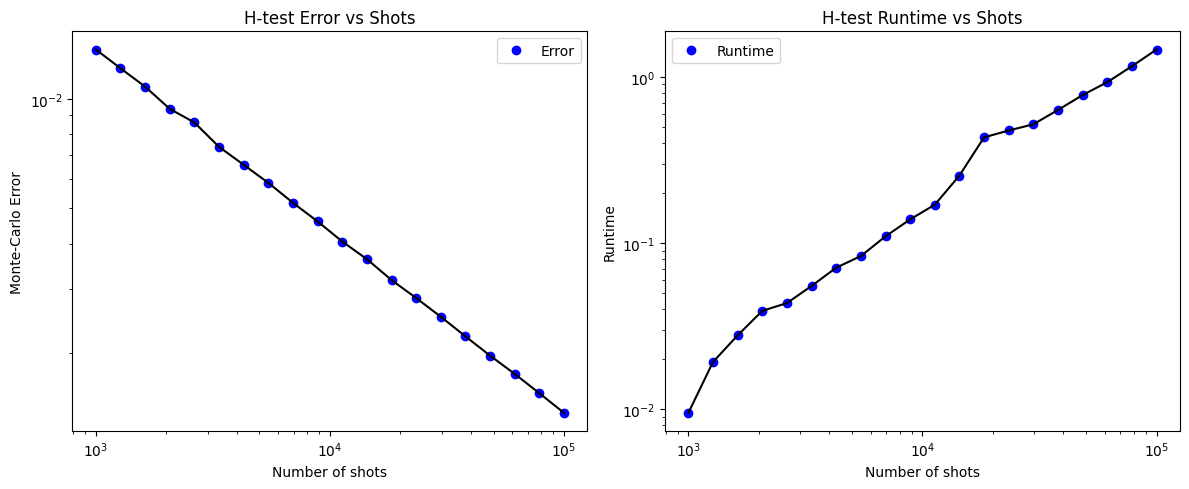

In [28]:
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

axes2[0].loglog(trials, errorHS, 'bo', label='Error')
axes2[0].loglog(trials, errorHS, 'k-')
axes2[0].set_title("H-test Error vs Shots")
axes2[0].set_xlabel("Number of shots")
axes2[0].set_ylabel("Monte-Carlo Error")
axes2[0].legend(loc='upper right')

axes2[1].loglog(trials, timesHS, 'bo', label='Runtime')
axes2[1].loglog(trials, timesHS, 'k-')
axes2[1].set_title("H-test Runtime vs Shots")
axes2[1].set_xlabel("Number of shots")
axes2[1].set_ylabel("Runtime")
axes2[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

## Hadamard Test Quantum Computer <a name="HTqc"></a>

We now follow the same procedure for the Hadamard tests on real quantum hadware.

In [29]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='rpi-rensselaer/general/general',
    token=token
)

#backend = service.backend("ibm_rensselaer")
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(backend)

In [30]:
HTre = re_HT(angle)
HTim = im_HT(angle)

In [31]:
HTre_trans = transpile(HTre, backend = backend, optimization_level = 3) # transpile real HT circuit
twodepth1 = HTre_trans.depth(lambda x: x.operation.name == "ecr") # get number of 2-qubit gates in path

HTim_trans = transpile(HTim, backend = backend, optimization_level = 3) # transpile imaginary HT circuit
twodepth2 = HTim_trans.depth(lambda x: x.operation.name == "ecr") # get number of 2-qubit gates in path

print(twodepth1, twodepth2)

2 2


In [32]:
# run both HT circuits on hardware
reHT_job = sampler.run([HTre_trans], shots=num_shots)
imHT_job = sampler.run([HTim_trans], shots=num_shots)

In [33]:
# get results for circuits
re_result = reHT_job.result()[0]
im_result = imHT_job.result()[0]

# gather counts for circuit
re_counts = re_result.data.c.get_counts()
im_counts = im_result.data.c.get_counts()

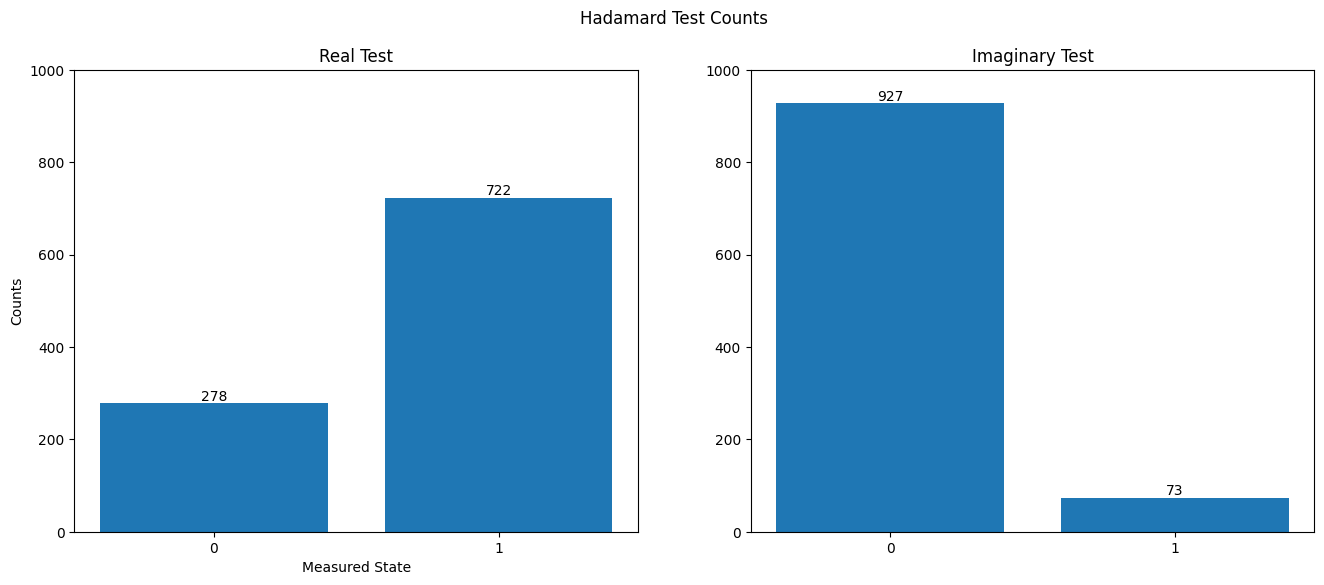

In [34]:
# plot counts for both circuits
fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bar2 = axes3[0].bar([0,1], [re_counts.get('0'), re_counts.get('1')])

axes3[0].bar_label(bar2, fmt = lambda x: int(x))
axes3[0].set_xticks([0,1])
axes3[1].set_xticks([0,1])

bar3 = axes3[1].bar([0,1], [im_counts.get('0'), im_counts.get('1')])
axes3[1].bar_label(bar3, fmt = lambda x: int(x))

axes3[0].set_ylim(0,num_shots)
axes3[1].set_ylim(0,num_shots)

axes3[0].set_xlabel('Measured State')
axes3[0].set_ylabel('Counts')
axes3[0].set_title('Real Test')
axes3[1].set_title('Imaginary Test')

fig3.suptitle('Hadamard Test Counts')
plt.show()

In [35]:
print('Real HT Runtime: ', reHT_job.usage_estimation.get('quantum_seconds'), 'sec')
print('Imaginary HT Runtime: ', imHT_job.usage_estimation.get('quantum_seconds'), 'sec')

Real HT Runtime:  2.1972422704295234 sec
Imaginary HT Runtime:  2.1972422704295234 sec


In [36]:
equation_number = 1 # use cosine to determine angle and sine to determine sign
# equation_number = 2 # use sine to determine angle and cosine to determine sign
# equation_number = 3 # use tan to determine angle
num_of_shots = num_shots
re_p0 = re_p1 = im_p0 = im_p1 = 0

if re_counts.get('0') is not None:
    re_p0 = re_counts['0']/num_of_shots
    
if re_counts.get('1') is not None:
    re_p1 = re_counts['1']/num_of_shots
    
if im_counts.get('0') is not None:
    im_p0 = im_counts['0']/num_of_shots
    
if im_counts.get('1') is not None:
    im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
im = im_p0 - im_p1

ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans/(2*pi))
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.32322049108517575
Exact phase angle:	 0.3333333333333333


In [46]:
trials = np.logspace(3, 5, 20)
Ns = []
errorHQC = []
timesHQCre = []
timesHQCim = []
for num_of_shots in trials:
    num_of_shots = int(num_of_shots)

    re_job = sampler.run([HTre_trans], shots=num_of_shots) # run both circuits on hardware
    im_job = sampler.run([HTim_trans], shots=num_of_shots)

    Reresult = re_job.result()[0] # gather results for both circuits
    Imresult = im_job.result()[0]

    Recounts = Reresult.data.c.get_counts() # gather counts for both circuits
    Imcounts = Imresult.data.c.get_counts()
    
    timesHQCre.append(re_job.usage_estimation.get('quantum_seconds')) # estimate run time of each circuit
    timesHQCim.append(im_job.usage_estimation.get('quantum_seconds'))

    re_p0 = re_p1 = im_p0 = im_p1 = 0

    # compute probabilities
    if re_counts.get('0') is not None:
        re_p0 = Recounts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = Recounts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = Imcounts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = Imcounts['1']/num_of_shots

    # compute expecation values
    re = re_p0 - re_p1
    im = im_p0 - im_p1

    # append error and convergence rate
    errorHQC.append((re_p0*(1 - re_p0)/num_of_shots)**(0.5))
    Ns.append(num_of_shots**(-0.5))

In [47]:
timesHQC = np.array(timesHQCre) + np.array(timesHQCre)
errorHQC = np.array(errorHQC)

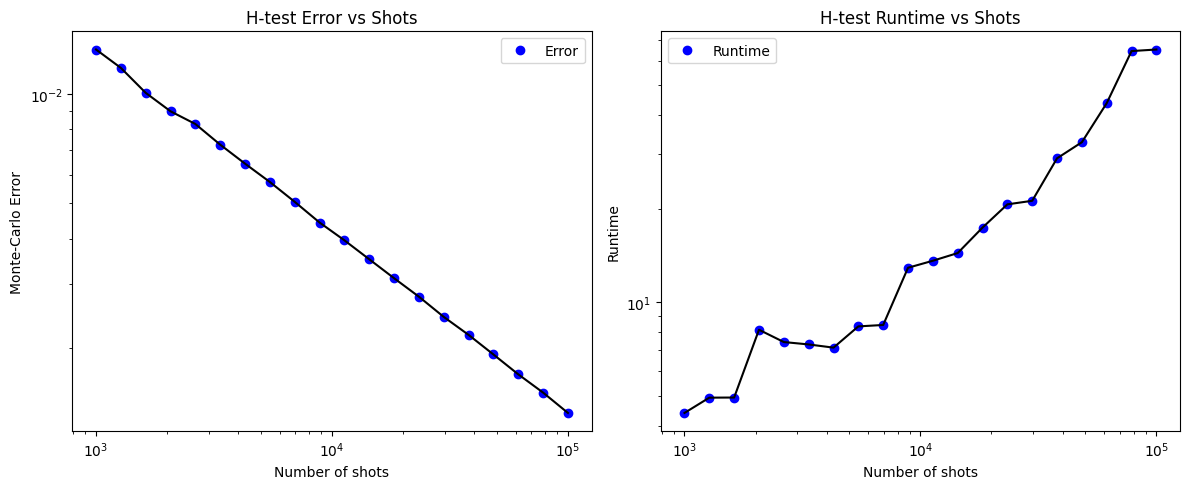

In [48]:
fig4, axes4 = plt.subplots(1, 2, figsize=(12, 5))

axes4[0].loglog(trials, errorHQC, 'bo', label='Error')
axes4[0].loglog(trials, errorHQC, 'k-')
axes4[0].set_title("H-test Error vs Shots")
axes4[0].set_xlabel("Number of shots")
axes4[0].set_ylabel("Monte-Carlo Error")
axes4[0].legend(loc='upper right')

axes4[1].loglog(trials, timesHQC, 'bo', label='Runtime')
axes4[1].loglog(trials, timesHQC, 'k-')
axes4[1].set_title("H-test Runtime vs Shots")
axes4[1].set_xlabel("Number of shots")
axes4[1].set_ylabel("Runtime")
axes4[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

## Quantum Phase Estimation Simulation <a name="QPEsim"></a>

Now the quantum phase estimation algorithm is run on the simulation for the unitary $U$ estimating $\varphi$.

In [37]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.measure(i,i)

In [38]:
ancilla_bits = 3
angle = 1/3

In [39]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.3333333333333333
Binary Representation of the phase angle:  0.010


In [40]:
def QPE(anc, angle):
    qc = QuantumCircuit(anc+1, anc)
    setup(qc, anc)
    qc.x(anc)
    qc.barrier()
    for i in range(anc):
        qc.cp((2*pi*angle)*2**(i), anc,i)
    
    add_inv_fourier_transform(qc,anc)
    
    #qr_ancilla = QuantumRegister(ancilla_bits)
    # print(qr_ancilla
    
    #qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
    qc.compose(QFT(anc, inverse = True), range(anc))
    return qc

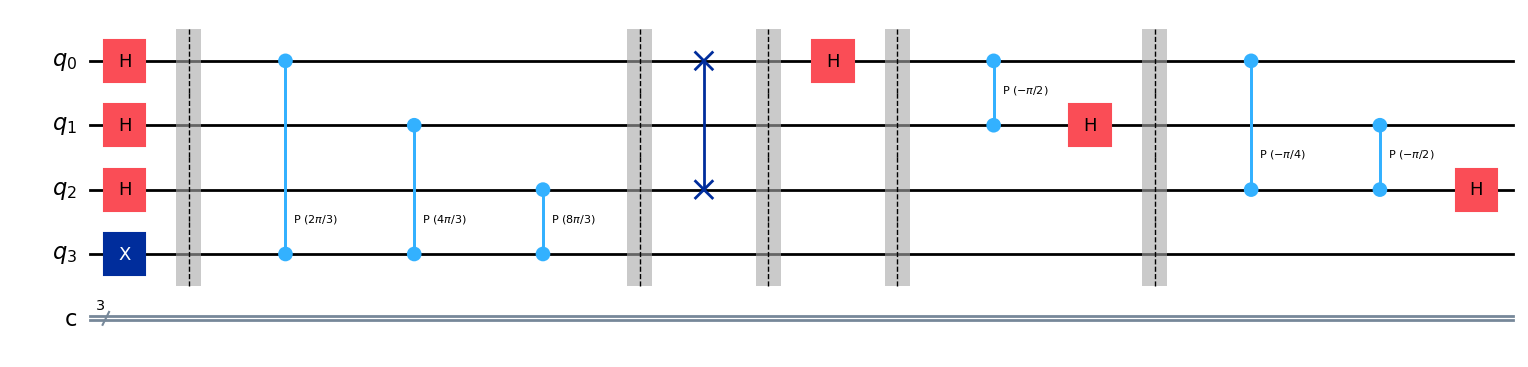

In [41]:
qc = QPE(ancilla_bits, angle)
qc.draw('mpl')

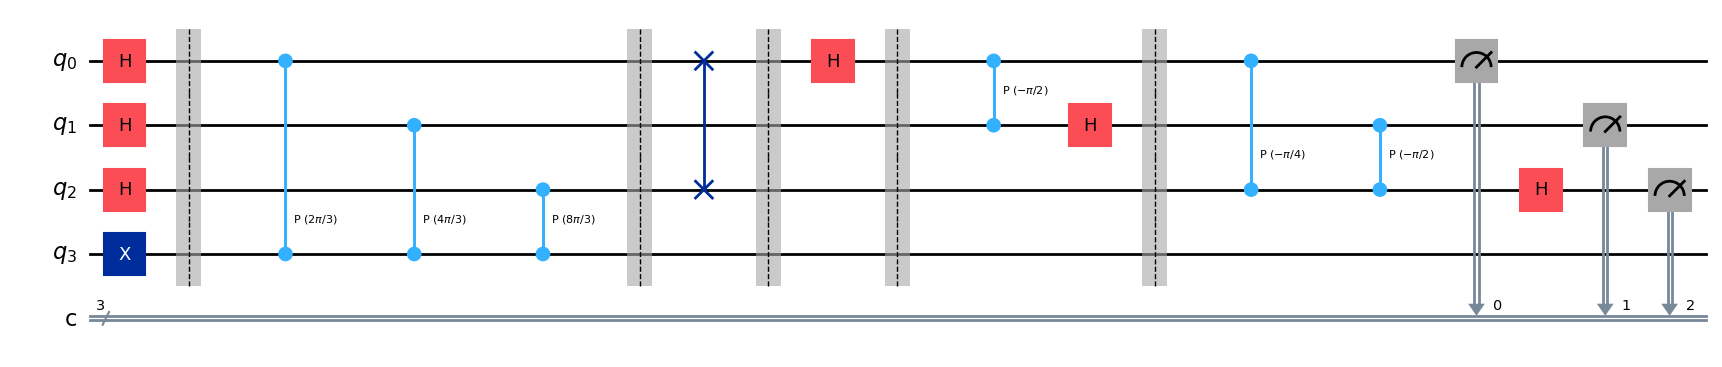

In [42]:
measure(qc, ancilla_bits)
qc.draw('mpl')

In [43]:
qctrans = transpile(qc, sim)
result = sim.run(qctrans, shots=num_shots).result()   
counts = result.get_counts()

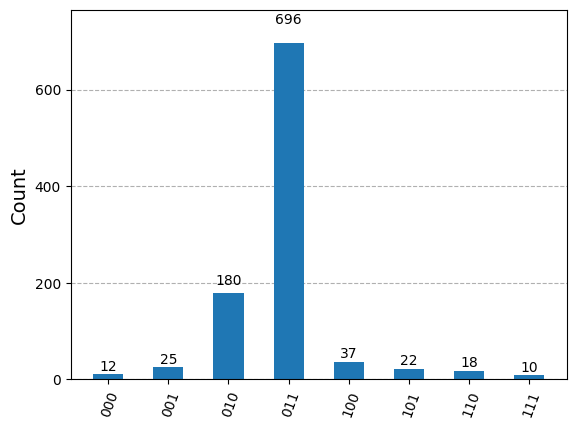

In [44]:
plot_histogram(counts)

In [45]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.011
Decimal Number with Equivalent Value: 0.375


With $3$ ancillary qubits run for $1000$ shots, it is clear that the QPE algorithm successfully estimates $\varphi$. We now cycle through $1 - 20$ ancillas appending the error and run time of each trial to a list to plot the error convergence and run time as the qubits increase on the simulation.

In [46]:
anc_bits = np.arange(1,21,1)
est = []
timesQPES = []
for bit in anc_bits:
    qc = QPE(bit, angle)
    measure(qc, bit)
    
    qctrans = transpile(qc, sim)
    result = sim.run(qctrans, shots=1000).result()   
    counts = result.get_counts()
    times = result.time_taken
    timesQPES.append(times)
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    est.append(decimal_num)
errorQPES = abs(angle - np.array(est))

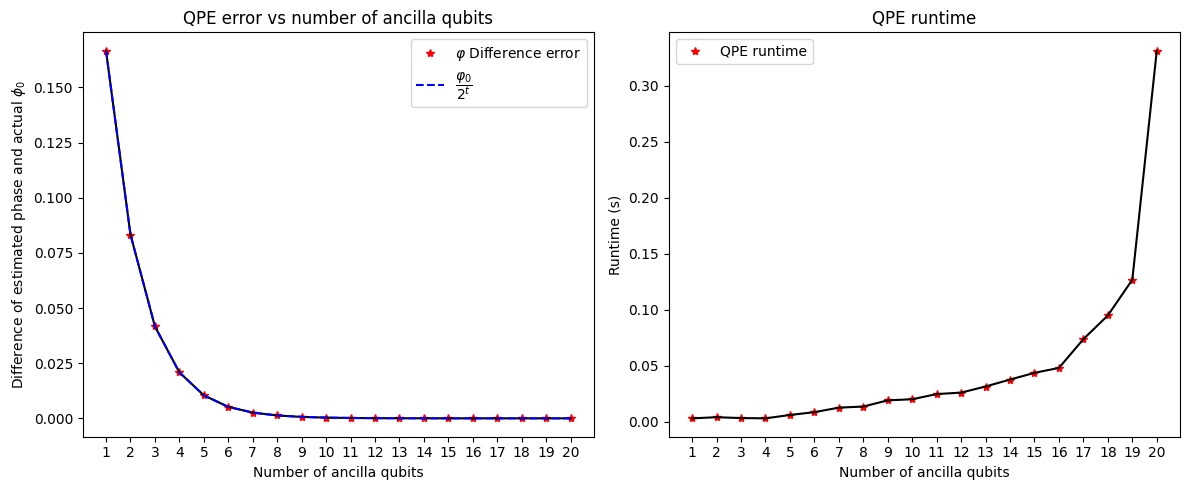

In [47]:
fig5, axs = plt.subplots(1, 2, figsize=(12, 5))  # 2 rows, 1 column

# First subplot: QPE error vs number of ancilla qubits
axs[0].plot(anc_bits, errorQPES, 'r*', label = '$\u03c6$ Difference error')
axs[0].plot(anc_bits, errorQPES, 'k-')
axs[0].plot(anc_bits, [angle / (2 ** t) for t in anc_bits], 'b--', label = '$\dfrac{\u03c6_0}{2^t}$')
axs[0].set_xticks(anc_bits)
axs[0].set_xlabel('Number of ancilla qubits')
axs[0].set_ylabel('Difference of estimated phase and actual $\phi_0$')
axs[0].set_title('QPE error vs number of ancilla qubits')
axs[0].legend(loc='upper right')

# Second subplot: QPE runtime
axs[1].plot(anc_bits, timesQPES, 'r*', label='QPE runtime')
axs[1].plot(anc_bits, timesQPES, 'k-')
axs[1].set_xticks(anc_bits)
axs[1].set_xlabel('Number of ancilla qubits')
axs[1].set_ylabel('Runtime (s)')
axs[1].set_title('QPE runtime')
axs[1].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Quantum Phase Estimation Quantum Computer <a name="QPEqc"></a>

We now follow the same procedure for the QPE algorithm on quantum hardware.

In [48]:
ancilla_bits = 3
angle = 1/3

In [49]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.3333333333333333
Binary Representation of the phase angle:  0.010


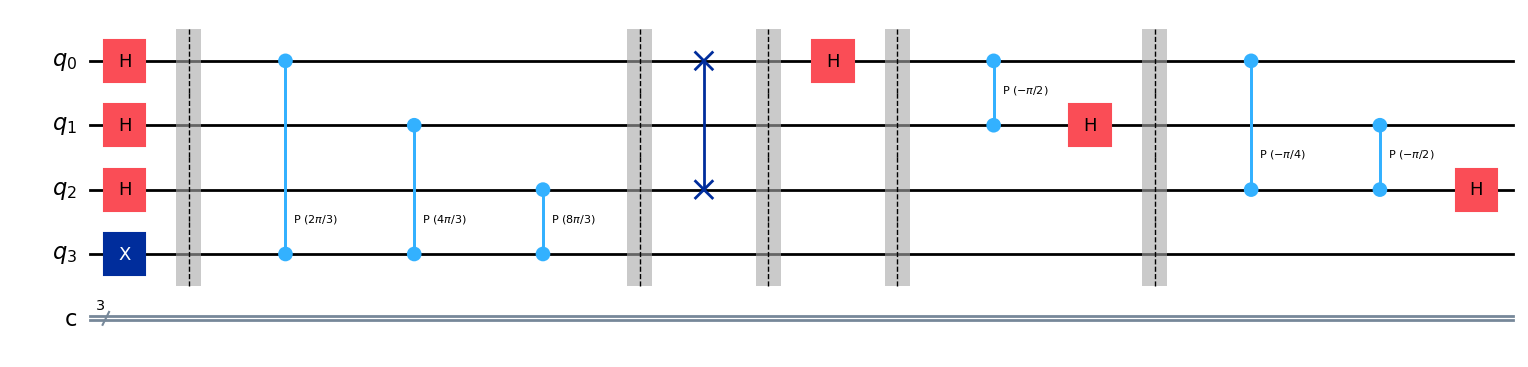

In [50]:
qc = QPE(ancilla_bits, angle)
qc.draw('mpl')

In [51]:
measure(qc, ancilla_bits)
#qc.draw('mpl')

In [52]:
qc_trans = transpile(qc, backend = backend, optimization_level=3)
twodepth = qc_trans.depth(lambda x: x.operation.name == "ecr")
print(twodepth)

18


In [53]:
QPE_job = sampler.run([qc_trans], shots = num_shots)

In [54]:
# get results for circuit
result = QPE_job.result()[0]

# gather counts for circuit
counts = result.data.c.get_counts()

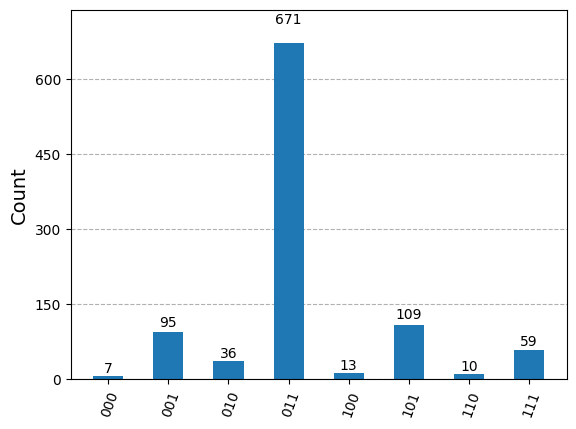

In [55]:
plot_histogram(counts)

In [56]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.011
Decimal Number with Equivalent Value: 0.375


In [71]:
anc_bits = np.arange(1,21,1)
est = []
timesQPEQC = []
for bit in anc_bits:
    qc = QPE(bit, angle)
    measure(qc, bit)
    
    qctrans = transpile(qc, backend = backend, optimization_level=3)
    qc_job = sampler.run([qctrans], shots = num_shots)
    qcresult = qc_job.result()[0]
    
    timesQPEQC.append(qc_job.usage_estimation.get('quantum_seconds'))
    counts = qcresult.data.c.get_counts() 
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    est.append(decimal_num)
errorQPEQC = abs(angle - np.array(est))

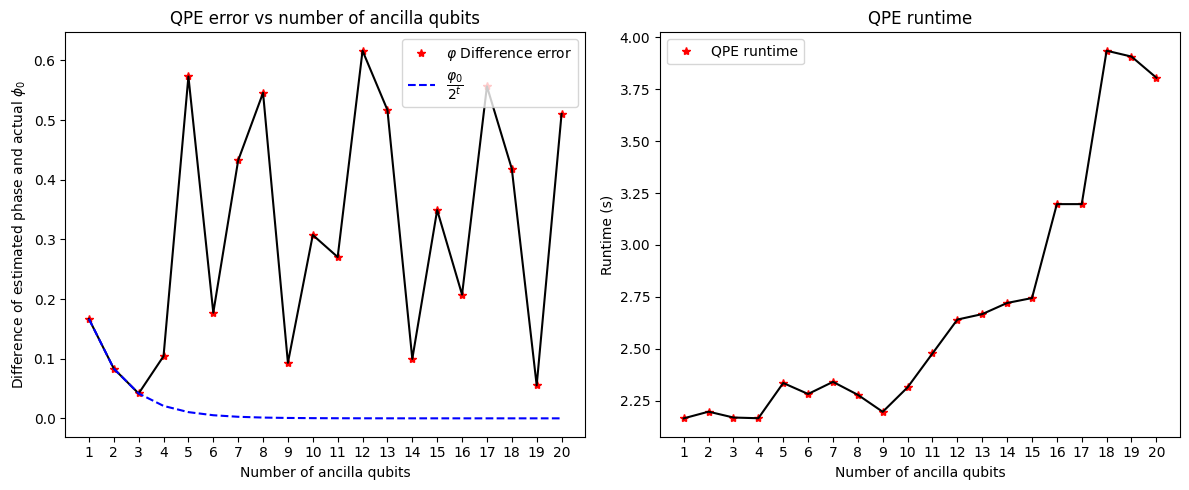

In [72]:
fig5, axs2 = plt.subplots(1, 2, figsize=(12, 5))  # 2 rows, 1 column

# First subplot: QPE error vs number of ancilla qubits
axs2[0].plot(anc_bits, errorQPEQC, 'r*', label = '$\u03c6$ Difference error')
axs2[0].plot(anc_bits, errorQPEQC, 'k-')
axs2[0].plot(anc_bits, [angle / (2 ** t) for t in anc_bits], 'b--', label = '$\dfrac{\u03c6_0}{2^t}$')
axs2[0].set_xticks(anc_bits)
axs2[0].set_xlabel('Number of ancilla qubits')
axs2[0].set_ylabel('Difference of estimated phase and actual $\phi_0$')
axs2[0].set_title('QPE error vs number of ancilla qubits')
axs2[0].legend(loc='upper right')

# Second subplot: QPE runtime
axs2[1].plot(anc_bits, timesQPEQC, 'r*', label='QPE runtime')
axs2[1].plot(anc_bits, timesQPEQC, 'k-')
axs2[1].set_xticks(anc_bits)
axs2[1].set_xlabel('Number of ancilla qubits')
axs2[1].set_ylabel('Runtime (s)')
axs2[1].set_title('QPE runtime')
axs2[1].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

With the error convergence and run time for both algorithms, we can now compare the algorithms for the $20$ trials.

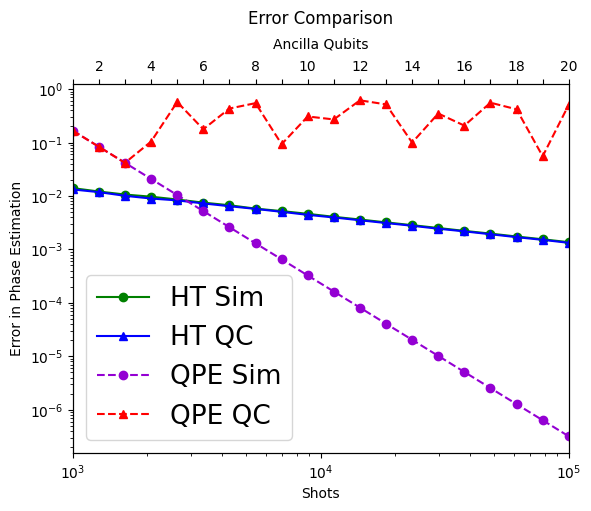

In [73]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials, errorHS, 'go-', label='HT Sim')
lin2, = ax.loglog(trials, errorHQC, 'b^-', label='HT QC')
lin3, = ax.loglog(trials, errorQPES, 'darkviolet', marker='o', ls='--', label='QPE Sim')
lin4, = ax.loglog(trials, errorQPEQC, 'r^--', label='QPE QC')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

# y log-scale
nticks = 9
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax2.yaxis.set_major_locator(maj_loc)
ax2.yaxis.set_minor_locator(min_loc)

ax.set_xlabel("Shots")
ax.set_ylabel("Error in Phase Estimation")
plt.title('Error Comparison', pad = 10)
ax.legend(loc='lower left', fontsize=19)

plt.show()

Looking at the error for each algorithm on the real quantum machine, the HT error is exactly the same as the theoretical output. However, the error for QPE is vastly different than theoretically predicted. For $t\leq3$ ancillary qubits, QPE follows the theory closely, but when $t>3$, the error does not decrease as predicted. With each increase in ancilla qubits, many new gates are introduced into the system creating too much noise for QPE to be effective. To mitigate this noise, Qiskit's built-in circuit optimization is used, where the argument$\texttt{ optimization\_level}$ equal to $0, 1, 2,$ or $3$ is set at the transpilation level where a higher optimization level mitigates the most noise. Notably, using$\texttt{ optimization\_level=3}$, we observe the current hardware to be still too noisy to yield accurate results. 

In [57]:
def get_depth(opt):
    for bit in anc_bit:
        qc = QPE(bit, angle)
        measure(qc, bit)

        qc_trans = transpile(qc, backend = backend, optimization_level=opt)
        twodepth = qc_trans.depth(lambda x: x.operation.name == "ecr")

        if opt == 0:           
            depth0.append(twodepth)
        elif opt == 1:           
            depth1.append(twodepth)
        elif opt == 2:           
            depth2.append(twodepth)
        else:
            depth3.append(twodepth)

In [58]:
anc_bit = np.arange(1,21,1)
depth0 = []
depth1 = []
depth2 = []
depth3 = []
get_depth(0)
get_depth(1)
get_depth(2)
get_depth(3)

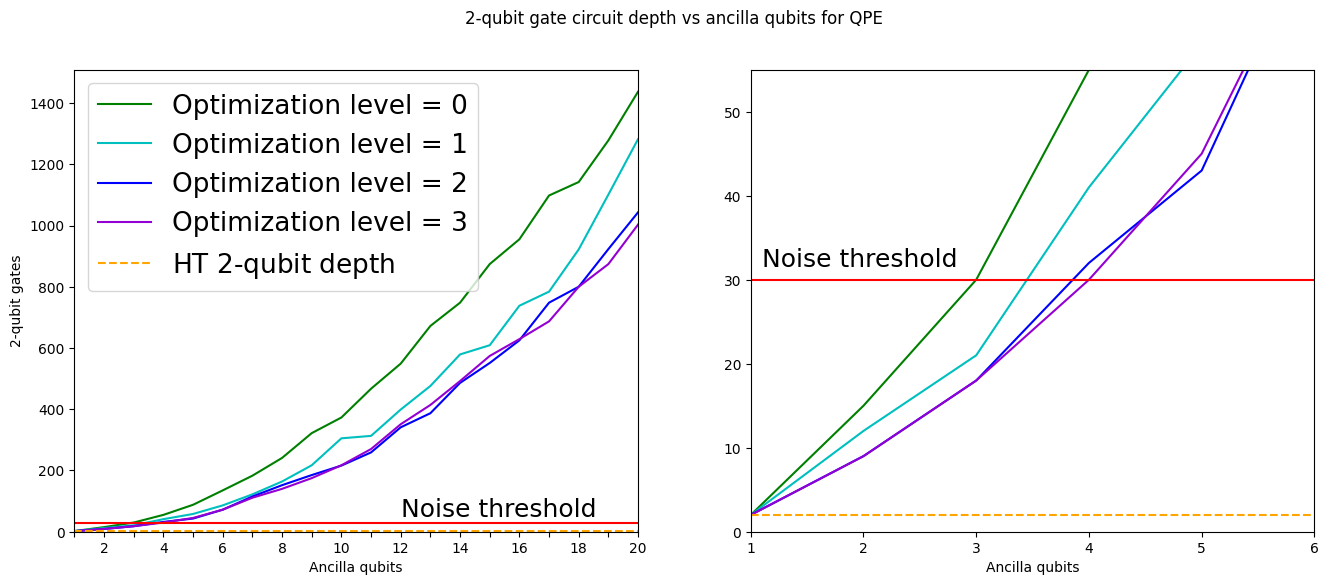

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(anc_bit, depth0, 'g', ls = '-', label = 'Optimization level = 0')
axes[0].plot(anc_bit, depth1, 'c', ls = '-', label = 'Optimization level = 1')
axes[0].plot(anc_bit, depth2, 'b', ls = '-', label = 'Optimization level = 2')
axes[0].plot(anc_bit, depth3, 'darkviolet', ls = '-', label = 'Optimization level = 3')
axes[0].set_xticks(anc_bit)

for label in axes[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

val = str(depth3[3])

axes[0].axhline(y=depth3[3], color='r', linestyle='-')
axes[0].axhline(y=2, color='orange', linestyle='--', label = 'HT $2$-qubit depth')
axes[0].text(12, 50, "Noise threshold", fontsize = 18, color = 'k')
axes[0].set_ylim(0)
axes[0].set_xlim(1,20)

fig.suptitle('2-qubit gate circuit depth vs ancilla qubits for QPE')
axes[0].legend(loc='upper left', fontsize = 19)
axes[0].set_xlabel('Ancilla qubits')
axes[0].set_ylabel('2-qubit gates')

axes[1].set_xlabel('Ancilla qubits')

axes[1].plot(anc_bit, depth0, 'g', ls = '-', label = 'Optimization level $= 0$')
axes[1].plot(anc_bit, depth1, 'c', ls = '-', label = 'Optimization level $= 1$')
axes[1].plot(anc_bit, depth2, 'b', ls = '-', label = 'Optimization level $= 2$')
axes[1].plot(anc_bit, depth3, 'darkviolet', ls = '-', label = 'Optimization level $= 3$')
axes[1].set_xticks(anc_bit)

axes[1].axhline(y=depth3[3], color='r', linestyle='-')
axes[1].axhline(y=2, color='orange', linestyle='--', label = 'HT depth')
axes[1].text(1.1, 31.5, "Noise threshold", fontsize = 18, color = 'k')
axes[1].set_ylim(0,55)
axes[1].set_xlim(1,6)

plt.show()
fig.tight_layout()

A common resource for analyzing the noise is the circuit depth. This integer number represents the number of gates that the circuit executes. The gates that are particularly affected by noise are the $2$-qubit gates. The plot above shows the number of $2$-qubit gates for QPE as a function of the ancillary qubits for different optimization levels. We observe that optimization levels $2$ and $3$ are more effective than levels $0$ or $1$ in reducing the number of 2-qubit gates. However, even with$\texttt{ optimization\_level=3}$, QPE with more than four ancillary qubits yields circuits that are too deep to be simulated on real quantum machines.

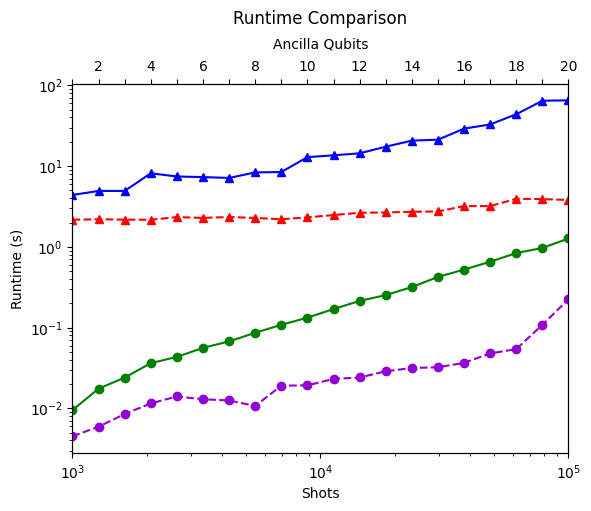

In [77]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials,timesQPES, color = 'darkviolet', marker ='o', ls = '--', label = 'QPE Sim Runtime')
lin2, = ax.loglog(trials,timesQPEQC,'r^', ls = '--', label = 'QPE QC Runtime')
lin3, = ax.loglog(trials,timesHS, 'go', ls = '-', label = 'HT Sim Runtime')
lin4, = ax.loglog(trials,timesHQC, 'b^', ls = '-', label = 'HT QC Runtime')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

ax.set_xlabel("Shots")
ax.set_ylabel("Runtime (s)")
plt.title('Runtime Comparison', pad = 10)

plt.show()

The plot above shows a runtime comparison of HT and QPE on classical and quantum machines. For HT, it is evident that the simulated experiment requires less runtime per shot compared to its quantum counterpart. Since the total runtime of HT scales directly with the runtime per shot, we observe that the runtime of HT on the quantum computer exhibits an offset, resulting in a consistently higher runtime compared to the classical machine. For QPE, the classical simulation runtime is lower than the runtime on the quantum computer, but increases exponentially. On the quantum computer however, the runtime remains close to linear. For the tested system, we observe a likely crossing of the respective runtimes at some close trial out of our range. 

At $1$ ancilla qubit for QPE and $10^3$ shots for HT, the circuits should be identical. So why is the HT runtime greater than that of QPE? While the real HT circuit is exactly the same as the QPE circuit, there is the addition of the imaginary HT circuit to correctly obtain the phase angle probabilistically, and thus HT takes about twice as long per shot as QPE for $1$ ancilla qubit.

On the simulation, to increase the precision of the estimated phase, the runtime of both the HT and QPE will also increase. However, on the quantum computer, regardless of the value of $t$, QPE's runtime remains nearly linear, while the HT's runtime exponentially increases with the number of shots. 